<h1>Model: Female Anger Vs Neutral</h1>

In [42]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [43]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input,AveragePooling2D, BatchNormalization, LeakyReLU

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from collections import defaultdict
from PIL import Image

<h2>Data Loading and Preparation</h2>

In [44]:
def getEmotionCode(x):
    part = x.split('_')
    if part[3] == 'NEU':
        return 0
    elif part[3] == 'ANG':
        return 1
    else:
        return 'Unknown'
    
def getEmotion(x):
    if x == 0:
        return 'NEU'
    elif x == 1:
        return 'ANG'
    else:
        return 'Unknown'
    
    
def getValidEmotion(x):
    part = x.split('_')
    
    if part[0] == 'M':
        return False
    if part[3] == 'ANG'or part[3] == 'NEU':
        return True 
    else:
        return False

[array([[[  0,   0,   4],
        [  0,   0,   4],
        [  0,   0,   4],
        ...,
        [  0,   0,   4],
        [  0,   0,   4],
        [  0,   0,   4]],

       [[  0,   0,   4],
        [  0,   0,   4],
        [  0,   0,   4],
        ...,
        [  0,   0,   4],
        [  0,   0,   4],
        [  0,   0,   4]],

       [[  0,   0,   4],
        [  0,   0,   4],
        [  0,   0,   4],
        ...,
        [  0,   0,   4],
        [  0,   0,   4],
        [  0,   0,   4]],

       ...,

       [[188,  57, 120],
        [188,  57, 120],
        [211,  67, 110],
        ...,
        [199,  61, 115],
        [178,  53, 123],
        [178,  53, 123]],

       [[188,  57, 120],
        [188,  57, 120],
        [211,  67, 110],
        ...,
        [199,  61, 115],
        [178,  53, 123],
        [178,  53, 123]],

       [[183,  55, 121],
        [183,  55, 121],
        [207,  64, 112],
        ...,
        [194,  59, 117],
        [173,  52, 124],
        [173,  52, 124]

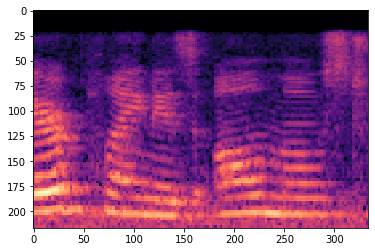

In [45]:
X_all = []
Y_all = []

image_folder_path = 'cremad/SpectogramInitial'
file_paths = [f for f in os.listdir(image_folder_path) if getValidEmotion(f)]

for file_name in file_paths:
    
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('RGB')
    spectrogram = np.array(spectrogram)
    X_all.append(spectrogram)
    Y_all.append(getEmotionCode(file_name))
    
print(X_all)
print(Y_all)
plt.imshow(X_all[0])


In [46]:
# print("Anger "+ Y_all.count('0'))
df=pd.DataFrame([getEmotion(f) for f in Y_all],columns=['Emotion'])
df['Emotion'].value_counts()


ANG    600
NEU    512
Name: Emotion, dtype: int64

In [47]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=2)

print(X_all)
print(Y_all)

(1112, 217, 334, 3)
(1112,)
[[[[0.         0.         0.01568628]
   [0.         0.         0.01568628]
   [0.         0.         0.01568628]
   ...
   [0.         0.         0.01568628]
   [0.         0.         0.01568628]
   [0.         0.         0.01568628]]

  [[0.         0.         0.01568628]
   [0.         0.         0.01568628]
   [0.         0.         0.01568628]
   ...
   [0.         0.         0.01568628]
   [0.         0.         0.01568628]
   [0.         0.         0.01568628]]

  [[0.         0.         0.01568628]
   [0.         0.         0.01568628]
   [0.         0.         0.01568628]
   ...
   [0.         0.         0.01568628]
   [0.         0.         0.01568628]
   [0.         0.         0.01568628]]

  ...

  [[0.7372549  0.22352941 0.47058824]
   [0.7372549  0.22352941 0.47058824]
   [0.827451   0.2627451  0.43137255]
   ...
   [0.78039217 0.23921569 0.4509804 ]
   [0.69803923 0.20784314 0.48235294]
   [0.69803923 0.20784314 0.48235294]]

  [[0.7372549  0.

In [48]:
# train /test= 80/20% split
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state = 123)



<h2>Model Building</h2>

In [49]:
def build_current_model():
    inp = Input(shape=(217,334,3))
    
    c1 = Convolution2D(filters=128,kernel_size=(5,5),strides=(2,2),padding='same')(inp)
    bt = BatchNormalization()(c1)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.2)(mpool)

    
    c2 = Convolution2D(filters=256,kernel_size=(3,3),strides=(2,2),padding='same')(mpool)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.3)(mpool)
    
    c3 = Convolution2D(filters=256,kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
    bt = BatchNormalization()(c3)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.3)(mpool)
    
    c4 = Convolution2D(filters=512,kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
    bt = BatchNormalization()(c4)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.4)(mpool)
    
    f = Flatten()(mpool)
    
    x_dense = Dense(2048)(f)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.4)(bt)

    
    x_dense = Dense(1024)(bt)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.3)(bt)
    
    x_dense = Dense(512)(bt)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.2)(bt)

    x_out = Dense(2, name='output', activation='sigmoid')(bt)
    
    model = Model(inputs=inp, outputs=x_out)
    model.compile(optimizer=Adam(lr=0.0001), 
                  loss='categorical_crossentropy', 
                  metrics = ['accuracy'])
    return model


In [50]:
model = build_current_model()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 217, 334, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 167, 128)     9728      
_________________________________________________________________
batch_normalization_7 (Batch (None, 109, 167, 128)     512       
_________________________________________________________________
activation_7 (Activation)    (None, 109, 167, 128)     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 84, 128)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 55, 84, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 42, 256)       2951

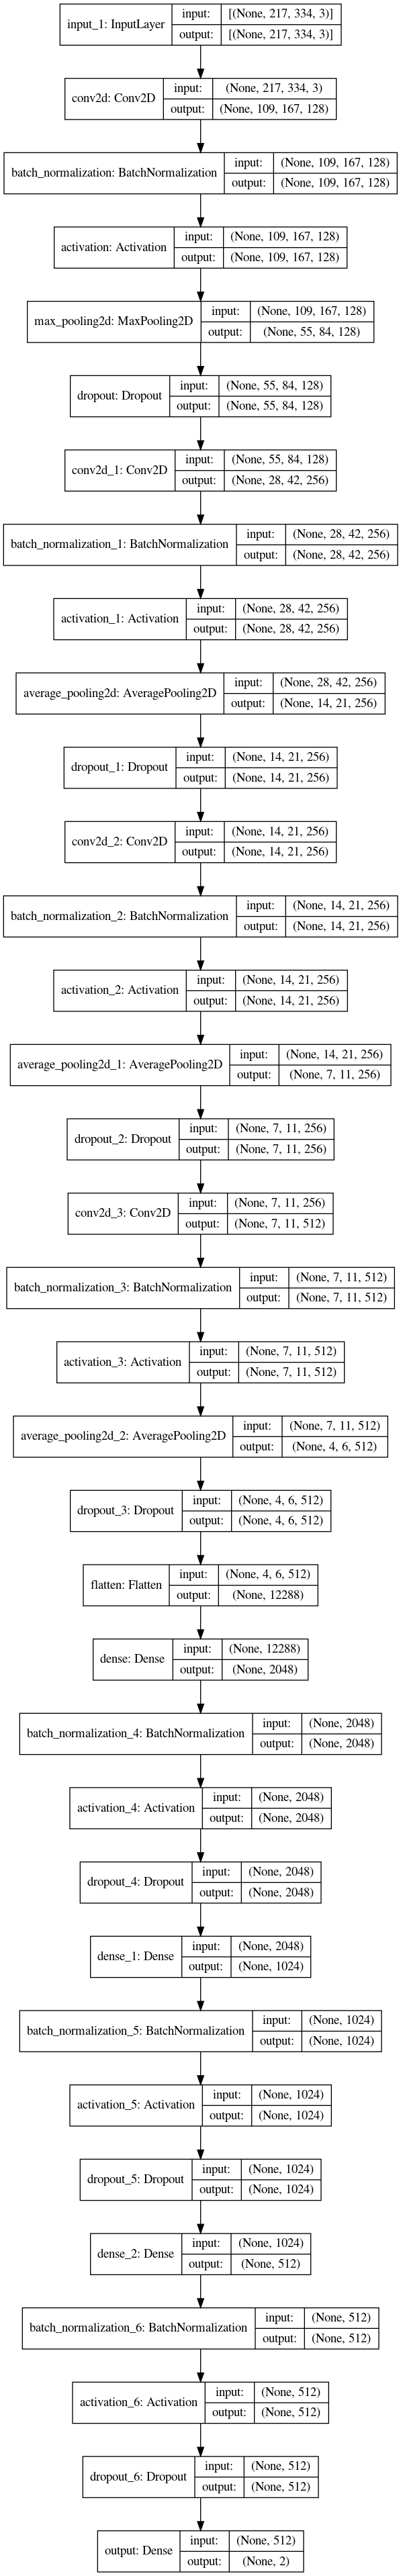

In [10]:
tf.keras.utils.plot_model(model, "Model-Ref7Var.png", show_shapes=True)

In [51]:

my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=15,verbose=1, mode='min',restore_best_weights=True)]
history = model.fit(X_train, Y_train, 
              epochs = 100, 
              validation_split=0.1, 
              verbose=1, 
              batch_size = 8,
                callbacks=my_callbacks)

history_info = history.history

Train on 800 samples, validate on 89 samples
Epoch 1/100
800/800 [==============================] - 3s 4ms/sample - loss: 0.4974 - acc: 0.7650 - val_loss: 0.6882 - val_acc: 0.5506
Epoch 2/100
800/800 [==============================] - 3s 3ms/sample - loss: 0.3658 - acc: 0.8575 - val_loss: 0.6833 - val_acc: 0.5506
Epoch 3/100
800/800 [==============================] - 3s 3ms/sample - loss: 0.3231 - acc: 0.8863 - val_loss: 0.6075 - val_acc: 0.6180
Epoch 4/100
800/800 [==============================] - 3s 3ms/sample - loss: 0.3198 - acc: 0.8625 - val_loss: 0.7661 - val_acc: 0.5506
Epoch 5/100
800/800 [==============================] - 3s 3ms/sample - loss: 0.3129 - acc: 0.8750 - val_loss: 1.0120 - val_acc: 0.5506
Epoch 6/100
800/800 [==============================] - 3s 3ms/sample - loss: 0.3110 - acc: 0.8763 - val_loss: 0.4158 - val_acc: 0.7753
Epoch 7/100
800/800 [==============================] - 2s 3ms/sample - loss: 0.2807 - acc: 0.8963 - val_loss: 0.4797 - val_acc: 0.8202
Epoch 8/10

<h2>Evaluation (Basic)</h2>

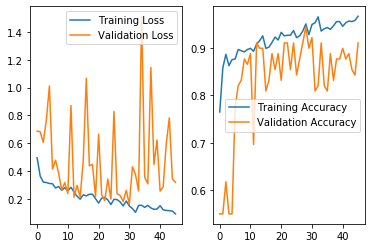

In [52]:
## Loss and accuracy history
_, axs = plt.subplots(ncols=2)
df_history_info = pd.DataFrame(history_info) 


sns.lineplot(data=df_history_info['loss'],ax=axs[0], label='Training Loss', legend='brief')
sns.lineplot(data=df_history_info['val_loss'],ax=axs[0], label='Validation Loss', legend='brief')

sns.lineplot(data=df_history_info['acc'],ax=axs[1], label='Training Accuracy', legend='brief')
sns.lineplot(data=df_history_info['val_acc'],ax=axs[1], label='Validation Accuracy', legend='brief')

In [53]:
def generate_actual_predicted(Y_pred, X_test, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted

[[115   3]
 [  2 103]]


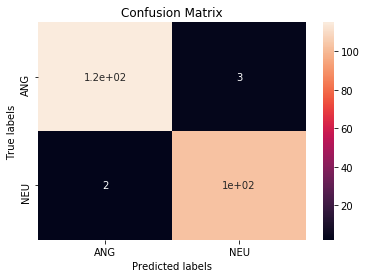

In [54]:
Y_pred = model.predict(X_test)
actual, predicted = generate_actual_predicted(Y_pred, X_test, Y_test)

##Confusion Matrix
from sklearn.metrics import confusion_matrix
actual_labeled = list()
predict_labeled = list()
for x,y in zip(actual,predicted):
    actual_labeled.append(getEmotion(x))
    predict_labeled.append(getEmotion(y))

labels = ['ANG','NEU']
cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

In [55]:
## Test accuracy
from sklearn.metrics import accuracy_score
print('accuracy', accuracy_score(actual, predicted))


accuracy 0.9775784753363229


In [56]:
## Precision, Recall, F1, Support
from sklearn.metrics import classification_report
print(classification_report(actual_labeled, predict_labeled,labels=labels))

              precision    recall  f1-score   support

         ANG       0.98      0.97      0.98       118
         NEU       0.97      0.98      0.98       105

    accuracy                           0.98       223
   macro avg       0.98      0.98      0.98       223
weighted avg       0.98      0.98      0.98       223



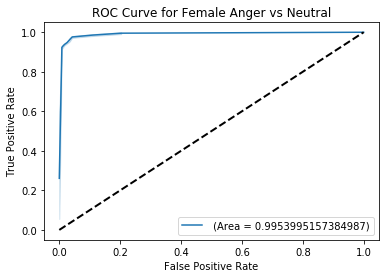

In [61]:
## ROC Curve

from sklearn.metrics import roc_curve, auc
import seaborn as sns



fpr, tpr, _ = roc_curve(Y_test[:,0], Y_pred[:,0])
# fpr, tpr, _ = roc_curve(Y_test[:,1], Y_pred[:,1])
# fpr,tpr,_=roc_curve(actual,predicted)
auc_val=auc(fpr, tpr)

#plot
_, axs = plt.subplots(ncols=1)
axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve for Female Anger vs Neutral')

sns.lineplot(x=fpr,y=tpr,label=' (Area = ' + str(auc_val) + ')', legend='brief')
# Diagonal line for comparison
plt.plot([0, 1], [0, 1], 'k--', lw=2)


In [ ]:
## Precision/Recall Curves



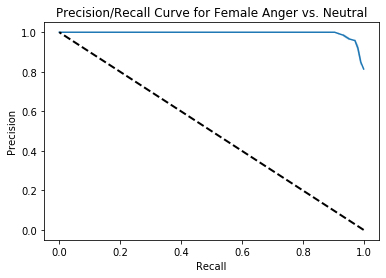

In [58]:
## Precision/Recall Curves per class
### The following curves are generated s.t each point is a model from differing thresholds
from sklearn.metrics import precision_recall_curve

_, axs = plt.subplots(ncols=1)
axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve for Female Anger vs. Neutral')

prec, rec, _ = precision_recall_curve(Y_test[:,0], Y_pred[:,0])
sns.lineplot(x=rec,y=prec,ax=axs)

# Diagonal line for comparison
plt.plot([1, 0], [0, 1], 'k--', lw=2)

<h2>K-Fold Training and Evaluation</h2>

In [ ]:
#Precision Mean and Standard Deviation
#Recall Mean and Standard Deviation
#F1 Measure Mean and Standard Deviation
#True Positive Rate. Mean and Standard Deviation
#False Negative Rate Mean and Standard Deviation
#Best/Worst ROC
#Best/Worst Precision/Recall
#Accuracy Mean and Standard Deviation

In [11]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve

all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()


all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()

all_accuracy = list()

n_classes=2
n_split=5
for train_index,test_index in KFold(n_split).split(X_all):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]

    # create and fit the model
    cv_model=build_current_model()
    history = cv_model.fit(x_train, y_train,
              batch_size=8,
              epochs=30,
              validation_split=0.1,
              verbose=1)
    
    #generate predictions
    y_pred = cv_model.predict(x_test)
    actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)
    
    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')

    
    curr_fpr = [0] * n_classes
    curr_tpr = [0] * n_classes
    for i in range(n_classes):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_prec = [0] * n_classes
    curr_rec = [0] * n_classes
    for i in range(n_classes):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    
    


Train on 2106 samples, validate on 235 samples
Epoch 1/30
2106/2106 [==============================] - 4s 2ms/sample - loss: 1.9727 - acc: 0.2711 - val_loss: 7.5599 - val_acc: 0.1574
Epoch 2/30
2106/2106 [==============================] - 3s 1ms/sample - loss: 1.6815 - acc: 0.3238 - val_loss: 2.1136 - val_acc: 0.2340
Epoch 3/30
2106/2106 [==============================] - 3s 1ms/sample - loss: 1.6457 - acc: 0.3295 - val_loss: 1.6396 - val_acc: 0.3532
Epoch 4/30
2106/2106 [==============================] - 3s 1ms/sample - loss: 1.6128 - acc: 0.3395 - val_loss: 1.8598 - val_acc: 0.4128
Epoch 5/30
2106/2106 [==============================] - 3s 1ms/sample - loss: 1.5794 - acc: 0.3647 - val_loss: 1.7919 - val_acc: 0.3362
Epoch 6/30
2106/2106 [==============================] - 3s 1ms/sample - loss: 1.5114 - acc: 0.3870 - val_loss: 1.7409 - val_acc: 0.3830
Epoch 7/30
2106/2106 [==============================] - 3s 1ms/sample - loss: 1.5097 - acc: 0.3832 - val_loss: 1.8516 - val_acc: 0.2894
E

In [12]:
print('precision mean by class', np.array(all_base_precision).mean(axis=0))
print('precision sdev by class', np.array(all_base_precision).std(axis=0))

print('macro precision mean', np.array(all_macro_precision).mean())
print('macro precision sdev', np.array(all_macro_precision).std())


print('recall mean', np.array(all_base_recall).mean(axis=0))
print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

print('f1 mean', np.array(all_f1).mean(axis=0))
print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



precision mean by class [0.52315394 0.66453705 0.39320845 0.57309849 0.49097089 0.45485376]
precision sdev by class [0.01152908 0.07975453 0.11357594 0.11674604 0.09924683 0.06712868]
macro precision mean 0.5166370975902755
macro precision sdev 0.019945256034584198
recall mean [0.25268878 0.69158497 0.549249   0.35067646 0.39813639 0.55202705]
recall sdev [0.22286912 0.09010108 0.24654446 0.18626173 0.14796653 0.04085438]
macro recall mean 0.465727109521185
macro recall sdev 0.021957521441771134
f1 mean [0.28760521 0.66720578 0.39097899 0.38449488 0.42109737 0.49287071]
f1 sdev [0.18255157 0.00590195 0.07186157 0.10032239 0.08665289 0.02059378]
macro f1 mean 0.4407088246135546
macro f1 sdev 0.02673494587440277
accuracy mean 0.4652604124850068
accuracy sdev 0.02677293892982706


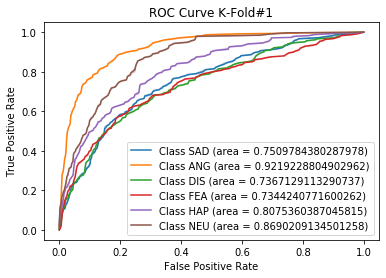

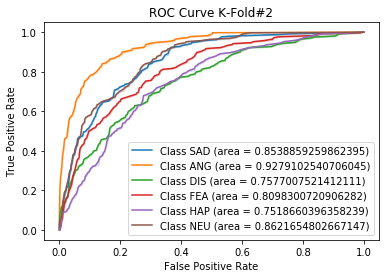

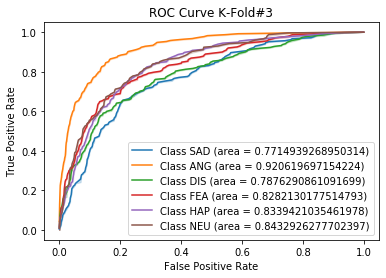

In [13]:
# Plot all K-Fold ROC curves
for i in range(3):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(6):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getEmotion(j) +' (area = ' + str(auc_val) + ')', legend='brief')
        

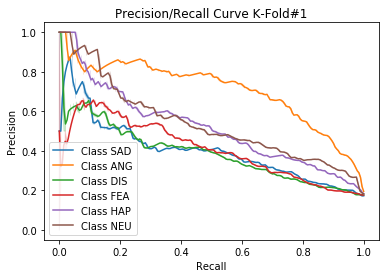

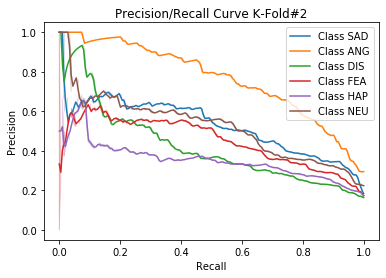

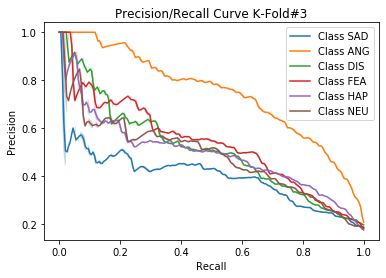

In [14]:
#Plot all K-Fold Precision/Recall curves
for i in range(3):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
    for j in range(6):
        sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getEmotion(j), legend='brief')

<h2>Storing/Loading history and model to file</h2>

In [51]:
#Store History
hist_df = pd.DataFrame(history.history) 
hist_json_file = 'ref7varhistory.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [51]:
#Load History 
history_info = pd.read_json('history.json')

In [52]:
##Save Model
model.save('ref7var_trained.model') #Save the model

In [53]:
## Load Model
model = tf.keras.models.load_model('mobile_net_trained.model') #Re load model